# Predicting flat prices
This project can be used for apartment price prediction based on a set of parameters by choosing the best model from the following:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- GradientBoostingRegressor;
- CatBoostRegressor;
- XGBRegressor.

INPUT: LandContour, GarageYrBlt, BsmtFullBath, 1stFlrSF, BsmtFinSF1, TotRmsAbvGrd, ExterQual, OpenPorchSF, Heating, Condition2, OverallQual, GarageCars, KitchenQual, GrLivArea, 2ndFlrSF, CentralAir, BsmtQual, TotalBsmtSF, Fireplaces.

OUTPUT: SalePrice

In [ ]:
!pip install catboost
!pip install xgboost

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Dataset preprocessing


## Constants

In [ ]:
LAND_CONTOUR_TYPES = {'Lvl': 1,
                      'Bnk': 2,
                      'HLS': 3,
                      'Low': 4}

EXTER_QUAL_TYPES = {'Ex': 1,
                    'Gd': 2,
                    'TA': 3,
                    'Fa': 4,
                    'Po': 5}

HEATING_TYPES = {'Floor': 1,
                 'GasA': 2,
                 'GasW': 3,
                 'Grav': 4,
                 'OthW': 5,
                 'Wall': 6}

CONDITION_2_TYPES = {'Artery': 1,
                     'Feedr': 2,
                     'Norm': 3,
                     'RRNn': 4,
                     'RRAn': 5,
                     'PosN': 6,
                     'PosA': 7,
                     'RRNe': 8,
                     'RRAe': 9}

KITCHEN_QUAL_TYPES = {'Ex': 1,
                      'Gd': 2,
                      'TA': 3,
                      'Fa': 4,
                      'Po': 5}

CENTRAL_AIR_TYPES = {'N': 1,
                     'Y': 2}

BSMT_QUAL_TYPES = {'Ex': 1,
                   'Gd': 2,
                   'TA': 3,
                   'Fa': 4,
                   'Po': 5,
                   'NA': 6}

LAND_CONTOUR_KEY = 'LandContour'
GARAGE_YR_BLT_KEY = 'GarageYrBlt'
FULL_BATH_KEY = 'FullBath'
FIRST_FLR_SF_KEY = '1stFlrSF'
BSMT_FIN_SF_1_KEY = 'BsmtFinSF1'
TOT_RMS_ABV_GRD_KEY = 'TotRmsAbvGrd'
EXTER_QUAL_KEY = 'ExterQual'
OPEN_PORCH_SF_KEY = 'OpenPorchSF'
HEATING_KEY = 'Heating'
CONDITION_2_KEY = 'Condition2'
OVERALL_QUAL_KEY = 'OverallQual'
GARAGE_CARS_KEY = 'GarageCars'
KITCHEN_QUAL_KEY = 'KitchenQual'
KITCHEN_ABV_GR_KEY = 'KitchenAbvGr'
GR_LIV_AREA_KEY = 'GrLivArea'
SECOND_FLR_SF_KEY = '2ndFlrSF'
CENTRAL_AIR_KEY = 'CentralAir'
BSMT_QUAL_KEY = 'BsmtQual'
TOTAL_BSMT_SF_KEY = 'TotalBsmtSF'
FIREPLACES_KEY = 'Fireplaces'

SALE_PRICE_KEY = 'SalePrice'
ID_KEY = 'Id'

MODEL_KEY = 'Model'
R2_KEY = 'R2'


## File creating functions


In [ ]:
def create_formatted_file(df, filename):
    df.to_csv(f'/content/{filename}', index=False, encoding='utf-8')


def create_result_file(df):
    df.to_csv(f'/content/result.csv', index=False, encoding='utf-8')

## Data types formatting

Data types formatting for not number types:

In [ ]:
def format_data_types(df):
    # filling empty fields
    for column in [LAND_CONTOUR_KEY, GARAGE_YR_BLT_KEY, FULL_BATH_KEY, TOT_RMS_ABV_GRD_KEY,
                   EXTER_QUAL_KEY, HEATING_KEY, CONDITION_2_KEY, GARAGE_CARS_KEY, KITCHEN_ABV_GR_KEY,
                   OVERALL_QUAL_KEY, KITCHEN_QUAL_KEY, CENTRAL_AIR_KEY, BSMT_QUAL_KEY, FIREPLACES_KEY]:
        df.loc[:, column] = df[column].fillna(df[column].mode()[0])

    for column in [FIRST_FLR_SF_KEY, BSMT_FIN_SF_1_KEY, OPEN_PORCH_SF_KEY,
                   GR_LIV_AREA_KEY, SECOND_FLR_SF_KEY, TOTAL_BSMT_SF_KEY]:
        df.loc[:, column] = df[column].fillna(df[column].mean())

    # data types processing
    df.loc[:, LAND_CONTOUR_KEY] = df[LAND_CONTOUR_KEY].map(LAND_CONTOUR_TYPES)
    df.loc[:, EXTER_QUAL_KEY] = df[EXTER_QUAL_KEY].map(EXTER_QUAL_TYPES)
    df.loc[:, HEATING_KEY] = df[HEATING_KEY].map(HEATING_TYPES)
    df.loc[:, CONDITION_2_KEY] = df[CONDITION_2_KEY].map(CONDITION_2_TYPES)
    df.loc[:, KITCHEN_QUAL_KEY] = df[KITCHEN_QUAL_KEY].map(KITCHEN_QUAL_TYPES)
    df.loc[:, CENTRAL_AIR_KEY] = df[CENTRAL_AIR_KEY].map(CENTRAL_AIR_TYPES)
    df.loc[:, BSMT_QUAL_KEY] = df[BSMT_QUAL_KEY].map(BSMT_QUAL_TYPES)

    return df

## Correlation coefficients

Calculating correlation coefficients in order to remove the columns that are the most dependent on each other.

In [ ]:
MAX_ACCEPTABLE_CORR = 0.8


def check_corr_emptiness(corr_coefficients):
    print('Corr Emptiness Check:')
    field_drop = [i for i in corr_coefficients if corr_coefficients[i].isnull().drop_duplicates().values[0]]
    print('\t', field_drop)


def check_corr_coefficients(corr_coefficients):
    print('Corr Coefficients Check:')
    for column in corr_coefficients:
        for row in corr_coefficients.index[corr_coefficients[column] > MAX_ACCEPTABLE_CORR]:
            if column != row:
                print('\t', column, " -> ", row, ": r^2 = ",
                      corr_coefficients[column][corr_coefficients.index == row].values[0])

When formatting the files while calculating the correlation coefficients, we learn the following:

    1stFlrSF  ->  TotalBsmtSF : r^2 =  0.8195299750050338
    TotRmsAbvGrd  ->  GrLivArea : r^2 =  0.8254893743088426
    GrLivArea  ->  TotRmsAbvGrd : r^2 =  0.8254893743088426
    TotalBsmtSF  ->  1stFlrSF : r^2 =  0.8195299750050338

Therefore, the following columns will be deleted:

    GR_LIV_AREA_KEY
    FIRST_FLR_SF_KEY

## Files formatting

In [ ]:
def format_file(filename):
    dataset = read_csv(f'/content/{filename}')

    dataset = format_data_types(dataset)

    corr_coefficients = dataset.corr()
    check_corr_emptiness(corr_coefficients)
    check_corr_coefficients(corr_coefficients)

    corr_fields = [GR_LIV_AREA_KEY, FIRST_FLR_SF_KEY]
    new_dataset = dataset.drop(corr_fields, axis=1)

    create_formatted_file(new_dataset, f'formatted_{filename}')

This function creates formatted file with replaced data types and deleted columns that were choosed by correlation coefficients calculating. We use it for ```train.csv``` and ```test_with_results.csv``` formatting.

# Models comparing and information






## Models comparison

Model comparison using RMSE in order to choose the best one for apartment price prediction.


In [ ]:
def compare_models(x_train, y_train):
    models = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor(),
              GradientBoostingRegressor(),
              CatBoostRegressor(verbose=False),
              XGBRegressor(objective='reg:squarederror'),
              ]
    model_names = ['LinearRegression',
                   'DecisionTreeRegressor',
                   'RandomForestRegressor',
                   'GradientBoostingRegressor',
                   'CatBoostRegressor',
                   'XGBRegressor'
                   ]
    print('MSE:')
    for i in range(len(models)):
        model = models[i]
        model_name = model_names[i]
        rmse = np.mean(np.sqrt(-cross_val_score(model, x_train, y_train.values.ravel(),
                                                cv=5, scoring="neg_mean_squared_error")))
        print('\t', model_name, round(rmse, 4))


    LinearRegression  36492.6932
    DecisionTreeRegressor  43780.7469
    RandomForestRegressor  31252.2144
    GradientBoostingRegressor  31285.3437
    CatBoostRegressor  30275.6273
    XGBRegressor  31789.3788

## Feature importances


Function to find out the importance of each parameter.

In [ ]:
def print_feature_importances(column_keys, model):
    print('Feature importances:')
    feature_importances = model.feature_importances_
    for i in range(len(feature_importances)):
        print('\t', round(feature_importances[i], 3), column_keys[i])

    1.832 LandContour
    3.826 GarageYrBlt
    4.336 FullBath
    9.033 BsmtFinSF1
    6.325 TotRmsAbvGrd
    2.576 ExterQual
    4.266 OpenPorchSF
    0.071 Heating
    0.341 Condition2
    21.776 OverallQual
    7.641 GarageCars
    4.928 KitchenQual
    0.749 KitchenAbvGr
    8.67 2ndFlrSF
    1.161 CentralAir
    2.605 BsmtQual
    14.639 TotalBsmtSF
    5.223 Fireplaces

# Program

Corr Emptiness Check:
	 []
Corr Coefficients Check:
	 1stFlrSF  ->  TotalBsmtSF : r^2 =  0.8195299750050338
	 TotRmsAbvGrd  ->  GrLivArea : r^2 =  0.8254893743088426
	 GrLivArea  ->  TotRmsAbvGrd : r^2 =  0.8254893743088426
	 TotalBsmtSF  ->  1stFlrSF : r^2 =  0.8195299750050338
Corr Emptiness Check:
	 []
Corr Coefficients Check:
MSE:
	 LinearRegression 36492.6932
	 DecisionTreeRegressor 42096.2039
	 RandomForestRegressor 31621.9515
	 GradientBoostingRegressor 31200.5127
	 CatBoostRegressor 30275.6273
	 XGBRegressor 31789.3788
RMSE CatBoostRegressor: 11956.068715587147
Feature importances:
	 1.832 LandContour
	 3.826 GarageYrBlt
	 4.336 FullBath
	 9.033 BsmtFinSF1
	 6.325 TotRmsAbvGrd
	 2.576 ExterQual
	 4.266 OpenPorchSF
	 0.071 Heating
	 0.341 Condition2
	 21.776 OverallQual
	 7.641 GarageCars
	 4.928 KitchenQual
	 0.749 KitchenAbvGr
	 8.67 2ndFlrSF
	 1.161 CentralAir
	 2.605 BsmtQual
	 14.639 TotalBsmtSF
	 5.223 Fireplaces


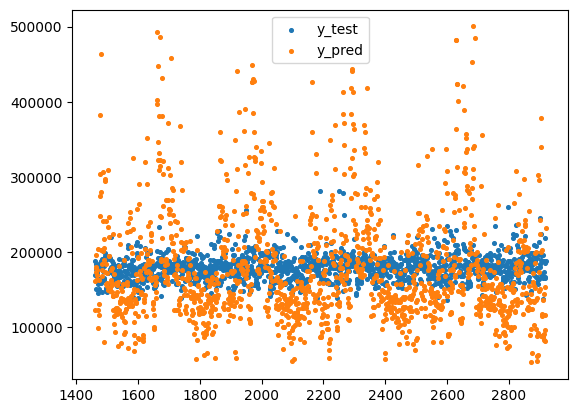

In [ ]:
# Data preparing
format_file('train.csv')
format_file('test_with_results.csv')

train_dataset = read_csv('formatted_train.csv')
test_dataset = read_csv('formatted_test_with_results.csv')
column_keys = train_dataset.columns.tolist()

y_train = train_dataset[[SALE_PRICE_KEY]]
x_train = train_dataset.drop([SALE_PRICE_KEY], axis=1)

y_test = test_dataset[[SALE_PRICE_KEY]]
x_test = test_dataset.drop([SALE_PRICE_KEY, ID_KEY], axis=1)

# Models comparison
compare_models(x_train, y_train)

# CatBoostRegressor prediction
model = CatBoostRegressor(verbose=False)
model = model.fit(x_train, y_train.values.ravel())

y_pred = model.predict(x_test)
rmse = np.mean(np.sqrt(-cross_val_score(model, x_test, y_test.values.ravel(), cv=5, scoring="neg_mean_squared_error")))
print(f'RMSE CatBoostRegressor: {rmse}')

print_feature_importances(column_keys, model)

# Saving results
result_dataset = DataFrame({ID_KEY: test_dataset[[ID_KEY]].values.ravel(),
                            SALE_PRICE_KEY: y_pred})
create_result_file(result_dataset)

# Graph for comparing results
plt.figure()
plt.scatter(test_dataset[[ID_KEY]].values.ravel(), y_test, s=7, label="y_test")
plt.scatter(test_dataset[[ID_KEY]].values.ravel(), y_pred, s=7, label="y_pred")
plt.legend()
plt.show()